# Background

Insurance is a financial safety net, helping you and your loved ones recover after something bad happens such as a fire, theft, lawsuit, or car accident. However, there are some challenges for insurance company. For example, the insurance application process is antiquated, and as a result, people are turned off. Therefore, insurance company like Prudential want to develop a predictive model that accurately classifies risk using a more automated approach so that it can improve the efficiency and reduce labor intensive for new and existing customers to get a quote while maintaining privacy boundaries. 

The goal of this project is to build a multi classification machine learning model to predict the risk level from 1 to 8 for each customer. The whole idea of this project is to get familiar with machine learning pipeline and implenment different algorithms to compare the performance. 

Data can be found here:https://www.kaggle.com/competitions/prudential-life-insurance-assessment/data

# 1. Data collection

In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb
from scipy.optimize import fmin_powell
from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import chart_studio.plotly as py
%matplotlib inline

warnings.filterwarnings('ignore')
train = pd.read_csv('/Users/weichenlu/Downloads/train.csv')
test = pd.read_csv('/Users/weichenlu/Downloads/test.csv')

# 2. Data Preprocessing

## 2.1 Handle missing values

In [2]:
train.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,...,0.056954,0.010054,0.045536,0.010710,0.007528,0.013691,0.008488,0.019905,0.054496,5.636837
std,22815.883089,0.160191,5.072885,0.282562,0.083107,0.739103,0.291949,0.197190,0.074239,0.089037,...,0.231757,0.099764,0.208479,0.102937,0.086436,0.116207,0.091737,0.139676,0.226995,2.456833
min,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19780.000000,1.000000,26.000000,0.076923,2.000000,3.000000,1.000000,0.238806,0.654545,0.225941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,39487.000000,1.000000,26.000000,0.230769,2.000000,3.000000,1.000000,0.402985,0.709091,0.288703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,59211.000000,1.000000,26.000000,0.487179,2.000000,3.000000,1.000000,0.567164,0.763636,0.345188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,79146.000000,2.000000,38.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [3]:
train.shape

(59381, 128)

In [4]:
test.shape

(19765, 127)

In [5]:
def count_missing_value(data):
    global null_dic
    null_dic = {}
    for i in range(data.shape[1]):
        my_null = data.iloc[:,i].isnull().sum()
        col_name = data.columns.values[i]
        per = data.iloc[:,i].isnull().mean()
        null_dic[col_name] = {'count':my_null,'percentage':per}
def filter_col():
    for i,j in list(null_dic.items()):
        if j['count'] == 0:
            del null_dic[i]
def col_with_null(data):
    count_missing_value(data)
    filter_col()
    return null_dic

In [6]:
train_null = col_with_null(train)
train_null

{'Employment_Info_1': {'count': 19, 'percentage': 0.00031996766642528756},
 'Employment_Info_4': {'count': 6779, 'percentage': 0.11416109529984339},
 'Employment_Info_6': {'count': 10854, 'percentage': 0.18278573954631952},
 'Insurance_History_5': {'count': 25396, 'percentage': 0.427678887186137},
 'Family_Hist_2': {'count': 28656, 'percentage': 0.4825786025833179},
 'Family_Hist_3': {'count': 34241, 'percentage': 0.5766322561088564},
 'Family_Hist_4': {'count': 19184, 'percentage': 0.323066300668564},
 'Family_Hist_5': {'count': 41811, 'percentage': 0.7041141105740893},
 'Medical_History_1': {'count': 8889, 'percentage': 0.14969434667654638},
 'Medical_History_10': {'count': 58824, 'percentage': 0.9906198952526902},
 'Medical_History_15': {'count': 44596, 'percentage': 0.7510146343106381},
 'Medical_History_24': {'count': 55580, 'percentage': 0.9359896263114464},
 'Medical_History_32': {'count': 58274, 'percentage': 0.981357673329853}}

In [7]:
test_null = col_with_null(test)
test_null

{'Employment_Info_1': {'count': 3, 'percentage': 0.00015178345560333924},
 'Employment_Info_4': {'count': 2137, 'percentage': 0.10812041487477865},
 'Employment_Info_6': {'count': 3787, 'percentage': 0.19160131545661524},
 'Insurance_History_5': {'count': 8105, 'percentage': 0.4100683025550215},
 'Family_Hist_2': {'count': 9880, 'percentage': 0.49987351378699724},
 'Family_Hist_3': {'count': 11064, 'percentage': 0.5597773842651151},
 'Family_Hist_4': {'count': 6677, 'percentage': 0.33781937768783205},
 'Family_Hist_5': {'count': 13624, 'percentage': 0.6892992663799646},
 'Medical_History_1': {'count': 2972, 'percentage': 0.15036681001770807},
 'Medical_History_10': {'count': 19564, 'percentage': 0.9898305084745763},
 'Medical_History_15': {'count': 14864, 'percentage': 0.7520364280293448},
 'Medical_History_24': {'count': 18585, 'percentage': 0.9402985074626866},
 'Medical_History_32': {'count': 19414, 'percentage': 0.9822413356944093}}

In [8]:
def get_per(data):
    global null_per,null_name
    null_per = []
    null_name = []
    for i,j in data.items():
        null_name.append(i)
        null_per.append(j['percentage'])

In [9]:
get_per(train_null)

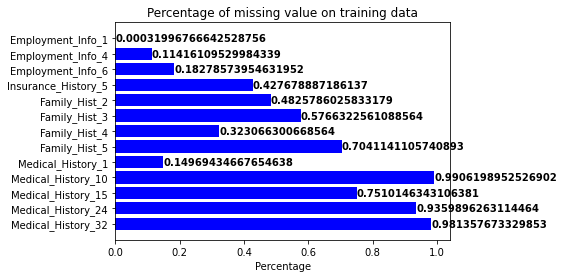

In [10]:
x = range(len(null_name))
fig, ax = plt.subplots() 
ax.barh(x, null_per, align='center',color='blue')
ax.set_yticks(x)
ax.set_yticklabels(null_name)
ax.invert_yaxis()
ax.set_xlabel('Percentage')
ax.set_title('Percentage of missing value on training data')
for i, v in enumerate(null_per):
    ax.text(v, i + .2, str(v), color='black', fontweight='bold')

In [11]:
get_per(test_null)

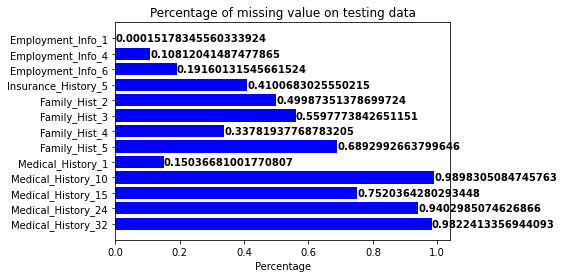

In [12]:
x = range(len(null_name))
fig, ax = plt.subplots() 
ax.barh(x, null_per, align='center',color='blue')
ax.set_yticks(x)
ax.set_yticklabels(null_name)
ax.invert_yaxis()
ax.set_xlabel('Percentage')
ax.set_title('Percentage of missing value on testing data')
for i, v in enumerate(null_per):
    ax.text(v, i + .2, str(v), color='black', fontweight='bold')

In [13]:
# combine train and test
all_data = pd.concat([train,test])

In [14]:
all_data['Employment_Info_1_null'] = np.where(all_data['Employment_Info_1'].isnull(), 1, 0)
all_data['Employment_Info_4_null'] = np.where(all_data['Employment_Info_4'].isnull(), 1, 0)
all_data['Employment_Info_6_null'] = np.where(all_data['Employment_Info_6'].isnull(), 1, 0)
all_data['Insurance_History_5_null'] = np.where(all_data['Insurance_History_5'].isnull(), 1, 0)
all_data['Family_Hist_2_null'] = np.where(all_data['Family_Hist_2'].isnull(), 1, 0)
all_data['Family_Hist_3_null'] = np.where(all_data['Family_Hist_3'].isnull(), 1, 0)
all_data['Family_Hist_4_null'] = np.where(all_data['Family_Hist_4'].isnull(), 1, 0)
all_data['Family_Hist_5_null'] = np.where(all_data['Family_Hist_5'].isnull(), 1, 0)
all_data['Medical_History_1_null'] = np.where(all_data['Medical_History_1'].isnull(), 1, 0)
all_data['Medical_History_10_null'] = np.where(all_data['Medical_History_10'].isnull(), 1, 0)
all_data['Medical_History_15_null'] = np.where(all_data['Medical_History_15'].isnull(), 1, 0)
all_data['Medical_History_24_null'] = np.where(all_data['Medical_History_24'].isnull(), 1, 0)
all_data['Medical_History_32_null'] = np.where(all_data['Medical_History_32'].isnull(), 1, 0)

In [15]:
all_data = all_data.drop(columns=['Medical_History_10','Medical_History_24','Medical_History_32'])

In [16]:
all_data.fillna(0, inplace=True)

## 2.2  Explore imbalance data

In [17]:
my_class_sample = train.groupby(['Response'])['Id'].count()
my_class_sample.rename('sample_counts')

Response
1     6207
2     6552
3     1013
4     1428
5     5432
6    11233
7     8027
8    19489
Name: sample_counts, dtype: int64

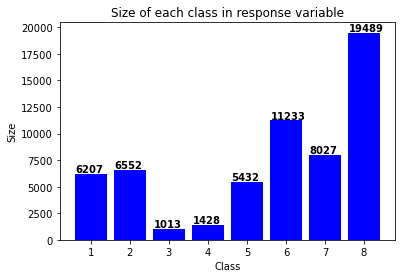

In [18]:
my_x = range(len(my_class_sample))
my_y = my_class_sample

fig, ax = plt.subplots() 
ax.bar(my_x,my_y,color='blue')
ax.set_ylabel('Size')
ax.set_xlabel('Class')
ax.set_title('Size of each class in response variable')
ax.set_xticklabels(range(9))
for i, v in enumerate(my_y):
    ax.text(i-0.4, v+150, str(v), color='black', fontweight='bold')


## 2.3  Feature Engineering And Fix Imbalance Data

In [19]:
all_data.Product_Info_2.value_counts()

D3    18753
D4    14071
A8     9140
D1     8611
D2     8344
E1     3711
A1     3219
A2     3072
A6     2733
A7     1823
A3     1564
B2     1446
A5     1009
C3      437
C1      377
C4      291
A4      263
C2      197
B1       85
Name: Product_Info_2, dtype: int64

In [20]:
# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

# factorize categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)
   
# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()


In [21]:
X_train = train.drop(columns=['Response','Id']).values
Y_train = train['Response'].values
X_test = test.drop(columns=['Response','Id']).values

In [22]:
print('Original dataset shape {}'.format(Counter(Y_train)))
sm = SMOTE(random_state=0)
X_res, Y_res = sm.fit_resample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(Y_res)))

Original dataset shape Counter({8: 19489, 6: 11233, 7: 8027, 2: 6552, 1: 6207, 5: 5432, 4: 1428, 3: 1013})
Resampled dataset shape Counter({8: 19489, 4: 19489, 1: 19489, 6: 19489, 2: 19489, 7: 19489, 3: 19489, 5: 19489})


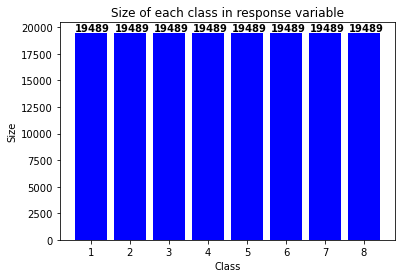

In [23]:
my_new_sample = [19489,19489,19489,19489,19489,19489,19489,19489]
my_x = range(len(my_new_sample))
my_y = my_new_sample

fig, ax = plt.subplots() 
ax.bar(my_x,my_y,color='blue')
ax.set_ylabel('Size')
ax.set_xlabel('Class')
ax.set_title('Size of each class in response variable')
ax.set_xticklabels(range(9))
for i, v in enumerate(my_y):
    ax.text(i-0.4, v+150, str(v), color='black', fontweight='bold')

# 4. Modeling And Evaluation

## 4.1 Build Evaluation Metrics 

In [24]:
# package for quadratic_weighted_kappa metrics seems broken, cannot import, 
# have to bring the source code of the metrics and run it here mannually.
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

def fit_model_with_kcv(foldnum,X,y,model):
    kf = KFold(n_splits=foldnum, shuffle=True, random_state= 0)
    global score_list
    score_list=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]       
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        score = quadratic_weighted_kappa(y_test,predict)
        score_list.append(score)

## 4.2 Train Model And Check Cross Validation Score

In [25]:
fit_model_with_kcv(5,X_res,Y_res,LogisticRegression(random_state = 0))
lr_ac = np.mean(score_list)
print('Logistic Regression - quadratic_weighted_kappa:{}'.format(np.mean(score_list)))

Logistic Regression - quadratic_weighted_kappa:0.24659166769666724


In [26]:
fit_model_with_kcv(5,X_res,Y_res,RandomForestClassifier(random_state = 0, n_estimators=200,n_jobs=-1))
rf_ac = np.mean(score_list)
print('Random Forest - quadratic_weighted_kappa:{}'.format(np.mean(score_list)))

Random Forest - quadratic_weighted_kappa:0.7316167702962088


## 4.3 Train Model And Check Kaggle Score

In [27]:
rf_smote = RandomForestClassifier(random_state = 0, n_estimators=200,n_jobs=-1)
rf_model_smote = rf_smote.fit(X_res, Y_res)
Y_predict_rf_smote = rf_model_smote.predict(X_test)
preds_out_rf_smote = pd.DataFrame({"Id": test['Id'].values, "Response": Y_predict_rf_smote})
preds_out_rf_smote = preds_out_rf_smote.set_index('Id')
preds_out_rf_smote.to_csv('Y_predict_rf_smote.csv')

In [28]:
lr_smote = LogisticRegression(random_state = 0)
lr_model_smote = lr_smote.fit(X_res, Y_res)
Y_predict_lr_smote = lr_model_smote.predict(X_test)
preds_out_lr_smote = pd.DataFrame({"Id": test['Id'].values, "Response": Y_predict_lr_smote})
preds_out_lr_smote = preds_out_lr_smote.set_index('Id')
preds_out_lr_smote.to_csv('Y_predict_lr_smote.csv')

## 4.4 Compare Cross Validation Score And Kaggle Score

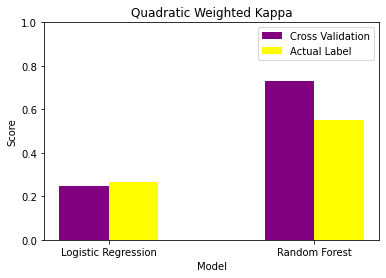

In [29]:
X_lab = ['Logistic Regression','Random Forest']
x = np.arange(2)
y = [lr_ac,rf_ac]
z = [0.26759,0.55306]#kaggle score
fig,ax = plt.subplots()
ax.set_ylim([0,1])
rects1 = ax.bar(x-0.12,y,color='purple',align='center',width = 0.24)
rects2 = ax.bar(x+0.12,z,color='yellow',align='center',width = 0.24)
ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_title('Quadratic Weighted Kappa')
plt.xticks(np.arange(2))
ax.legend(('Cross Validation', 'Actual Label'))
ax.set_xticklabels(X_lab)

plt.show()

# 5. Conclusion And Improvment

In a nutshell, logistic regression seems not performing well in both cross validation and actual test set. The random forest model performs significantly better, even though it seems a bit overfitting in cross validation, it still gives me the highest accuracy which is around 55.3% compared to the actual test data set on Kaggle. Since data is from real company, most of the information has been censored or replaced with dummy features due to privacy. I cannot tell many business insights other than accuracy. But I believe the overall process is a good practice and I believe company will find a good use of these models in their business. In terms of the model performance, there are still some improvements can be done in the future. For example, I can apply an offset to select predictions generated from the model. This is an effort to remove the effects of a group of nuisance variables from the target variable prior to running the model to omitted variables bias